In this note book we will use BI to quantify the uncertainty of pendant drop tensiometry (PDT)
First, we use generator: [genSingleDrop] to generate a standard drop and the add white noise on it to estimate the noise while edge detection and curve fitting.

In [1]:
import numpy as np
import cv2 
from matplotlib import pyplot as plt
import os
from fun_genSingleDrop import *

r0,z0=genSingleDrop(73.04,15,rneedle=0.5,output=1)

In [2]:
import random
# fix the seed for the RANDOM
RANDOM_SEED=5109
np.random.seed(RANDOM_SEED)

# add white noise on z and r

wn_sigma=0.1
r_w=r0+0
z_w=z0+0

for i in range (r_w.size):
    r_w[i] += random.gauss(0,wn_sigma) # wn_mu=0, because it's white noise
    z_w[i] += random.gauss(0,wn_sigma)

In [52]:
# try to use the polyfit
parameter_polyfited=np.polyfit(z_w,r_w,6)
function_polyfited=np.poly1d(parameter_polyfited)
r_predict=function_polyfited(z_w)

plt.plot(z0,r0)
plt.plot(z_w,r_w,'.')
plt.axis('equal')
plt.show()

In [3]:
import numpy as np
from scipy.optimize import minimize

# Define a function to calculate the distance
def calcu_distance_to_curve(x, known_points, point):
    # x is a parameter indicating the position on the curve
    # Calculate the points on the curve
    curve_point = np.array([x, np.interp(x, known_points[:, 0], known_points[:, 1])]).reshape(2)
    # Calculate the square of the distance as the optimisation objective
    distance_squared = np.sum((curve_point - point) ** 2)
 
    return distance_squared

def calcu_minimize_distance_to_curve(x,fx,measurement_points):

    bounds_left=np.min(x)

    # Points on a known curve
    known_points=np.vstack((x,fx))
    known_points=np.transpose(known_points) 

    # The point at which the distance is to be calculated
    point = measurement_points # (z,r)

    # Finding the shortest distance using a gradient descent algorithm
    result = minimize(calcu_distance_to_curve,x0=bounds_left/2, args=(known_points, point,), bounds=[(bounds_left, 0)],)

    # Shortest distance
    min_distance = np.sqrt(result.fun)

    return min_distance,point

Now, we assume we don't know the square error $\sigma_{noise}$ of the white noise, and then we try to find which surface tension $\gamma$ can minimise it.

First, we try $\gamma$=75 and $V$=15 to see the SE of it.

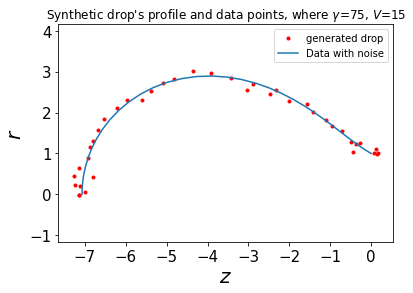

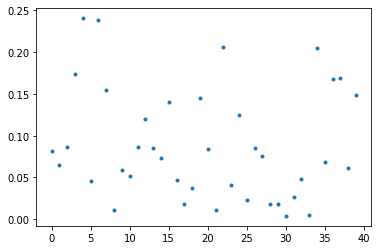

In [38]:
gamma,volume=[75,15]
r,z=genSingleDrop(gamma,volume,0.5,1)
distances=[]
# For every point in measurement point (with white noise), 
# we calculate the distance to curve, 
# and finally calculate the square error.
for i in range(r_w.shape[0]):
    #print(z_w[i],r_w[i])
    point=np.array([z_w[i],r_w[i]])
    min_distance,_=calcu_minimize_distance_to_curve(z,r,point)
    #print(min_distance)
    distances.append(min_distance)
distances=np.asarray(distances)
MSE=np.sqrt(np.mean(distances**2)).item() 


plt.plot(z_w,r_w,'.',color='r')
plt.plot(z,r)
plt.xlabel("$z$",fontdict={'family': 'Times New Roman', 'size':20})
plt.ylabel("$r$",fontdict={'family': 'Times New Roman', 'size':20})
plt.title('Synthetic drop\'s profile and data points, where $\gamma$=%i, $V$=%i' %(gamma,volume))
plt.legend(['generated drop','Data with noise'])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis('equal')
plt.show()

plt.plot(distances,'.')
plt.show()


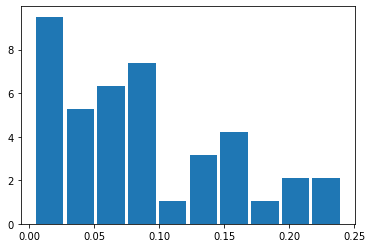

In [42]:
plt.hist(distances, bins=10, rwidth=0.9, density=True,)
plt.show()

Then, we calculate SEs for different $\gamma$ but the same volume, where $\gamma \in $[61,100] and $V$=15. 

In [35]:
def calcu_MSE(gamma,volume,z_w,r_w):
    '''Given surface tension, volume and experimental data points (with noise), 
    then calculate the MSE of these points to the profile of the droplet
    gamma   --> surface tension [float] ;
    volume  --> volume          [float] ;
    z_w     --> Data coordinates along the direction of gravity ;
    r_w     --> Data coordinates along the direction of radius  ;
    '''
    r,z=genSingleDrop(gamma,volume,0.5,1)
    distances=[]
    # For every point in measurement point (with white noise), 
    # we calculate the distance to curve, and finally calculate the square error.
    for i in range(r_w.shape[0]):
        #print(z_w[i],r_w[i])
        point=np.array([z_w[i],r_w[i]])
        min_distance,_=calcu_minimize_distance_to_curve(z,r,point)
        #print(min_distance)
        distances.append(min_distance)
    distances=np.asarray(distances)
    MSE=np.sqrt(np.mean(distances**2))
    MSE=MSE.astype(float)
    return MSE,distances

In [36]:
from tqdm import tqdm
SurfaceTensions=[]
MSEs=[]
volume=15
for gamma in tqdm(np.arange(61,101,1)):
    MSE,_=calcu_MSE(gamma,volume,z_w=z_w,r_w=r_w)
    SurfaceTensions.append(gamma)
    MSEs.append(MSE)

100%|██████████| 40/40 [00:16<00:00,  2.44it/s]


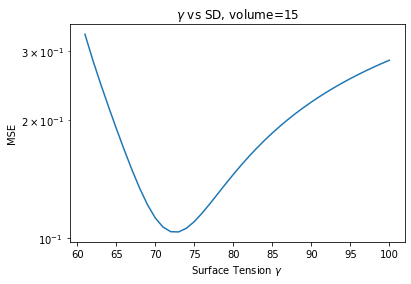

In [37]:
plt.plot(SurfaceTensions,MSEs)
plt.xlabel('Surface Tension $\gamma$')
plt.ylabel('MSE')
plt.yscale('log')
plt.title('$\gamma$ vs SD, volume=%i' %volume)
plt.show()